In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

In [3]:
import shap
import torch
import shutil
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random

from losses import MSELoss
from utils import load_pairs_from_csv, MetricLogger
from train import create_image_transforms, save_checkpoint
from modules import ResNetRegressionNet, ResNetRegressionNetWithAuxiliary
from datasets import FlowPhotoDataset, FlowPhotoDatasetWithAuxiliary, FlowPhotoRankingPairsDatasetWithAuxiliary

seed = 507

/home/jeff/miniconda3/envs/fpe-rank/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from pathlib import Path

run_dir = Path("/home/jeff/data/fpe/experiments/20241113-WB0-aux-reg/runs/aux_reg_01")
data_dir = run_dir / "input"
output_dir = run_dir / "output"
model_dir = run_dir / "model"
checkpoint_dir = run_dir / "checkpoints"

images_dir = Path("/home/jeff/data/fpe/images")
auxiliary_features = ["obs_z"]

# Load and split data
pairs_df = load_pairs_from_csv(data_dir / "train-pairs.csv")
pairs_df.head()


,split,pair,image_id_1,timestamp_1,filename_1,image_id_2,timestamp_2,filename_2,label,obs_1,...,obs_2,prcp_2,jday_2,dhour_2,zero_2,rand_2,obs_z_2,prcp_z_2,jday_z_2,dhour_z_2
0,train,18,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,-1,-0.065502,...,1.139879,0.00,39,13.000000,0,0.553448,0.508599,0.000000,0.104396,0.500012
1,train,18,442036,2022-02-08 18:00:00,imagesets/e8d465f6-5784-4231-967f-9000428e9748...,664978,2022-07-13 20:45:01,imagesets/6cd6870a-0260-4687-840d-1ac4ac2794e4...,1,1.139879,...,-0.065502,11.81,194,16.750278,0,0.452459,0.234521,0.179429,0.530220,0.812542
2,train,30,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,1,1.152288,...,0.553859,0.00,157,17.250278,0,0.429406,0.375350,0.000000,0.428571,0.854210
3,train,30,660978,2022-06-06 21:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,2018327,2023-03-07 22:30:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,-1,0.553859,...,1.152288,0.00,66,17.500278,0,0.692919,0.511421,0.000000,0.178571,0.875043
4,train,33,1645271,2023-01-01 22:29:59,imagesets/265292ae-007e-4a94-a86c-e01028d85c1f...,2084157,2023-04-15 12:15:01,imagesets/e33129ab-64df-48f7-9380-1be3258b577f...,0,1.260087,...,1.170242,4.66,105,8.250278,0,0.821098,0.515503,0.070799,0.285714,0.104192


In [6]:
train_df = pairs_df[pairs_df['split'] == "train"]
val_df = pairs_df[pairs_df['split'] == "val"]

train_ds = FlowPhotoDataset(train_df, images_dir, col_image_id="image_id_1", col_timestamp="timestamp_1", col_filename="filename_1", col_label="obs_1")
img_mean, img_std = train_ds.compute_mean_std(1000)
print(f"Image mean: {img_mean}, std: {img_std}")

100%|██████████| 500/500 [00:17<00:00, 28.84it/s]

Image mean: [0.40918706 0.41736542 0.37527723], std: [0.27850742 0.28033317 0.27329798]


In [7]:
# Calculate shapes using crop_ratio
input_size = 480
crop_ratio = 0.8
decolorize = False
augment = True
normalize = True
rotation_degrees = 10

img, label = train_ds[0]
print(f"Image shape: {img.shape}")

Image shape: torch.Size([3, 1536, 2048])


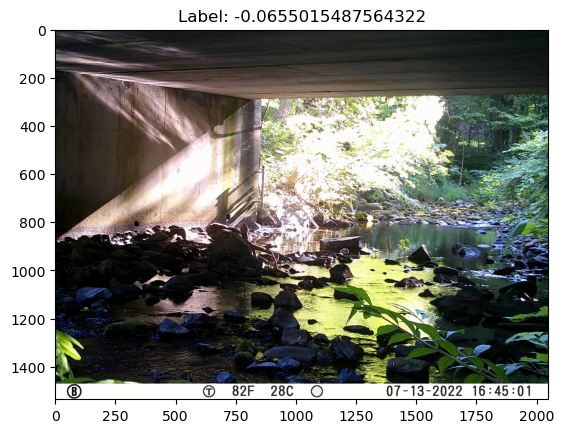

In [8]:
image = train_ds.get_image(0)
plt.imshow(image.permute(1, 2, 0).numpy())
plt.title(f"Label: {label}")
plt.show()

In [9]:
aspect = image.shape[2] / image.shape[1]
image_shape = image.shape
resize_shape = [input_size, int(input_size * aspect)]
input_shape = [
    int(input_size * crop_ratio), 
    int(input_size * crop_ratio * aspect)
]
print(f"Resize shape: {resize_shape}, input shape: {input_shape}")


Resize shape: [480, 640], input shape: [384, 512]


In [10]:
# Create transforms with rotation parameter
transforms = create_image_transforms(
    resize_shape, input_shape,
    means=img_mean, stds=img_std,
    decolorize=decolorize,
    augmentation=augment,
    normalization=normalize,
    rotation_degrees=rotation_degrees
)

train_ds.transform = transforms["train"]
val_ds = FlowPhotoDataset(
    val_df,
    images_dir,
    col_image_id="image_id_1",
    col_timestamp="timestamp_1",
    col_filename="filename_1",
    col_label="obs_1",
    transform=transforms["eval"]
)

In [11]:
# Create dataloaders
batch_size = 64
num_workers = 4

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [12]:
input_shape

[384, 512]

In [13]:
model = ResNetRegressionNet(
    input_shape=(3, input_shape[0], input_shape[1]),
    transforms=transforms,
    resnet_size=18,
    truncate=2
)

# Freeze resnet backbone initially
for p in list(model.children())[0].parameters():
    p.requires_grad = False

# model = nn.DataParallel(model, device_ids=[0])
model = model.to(device)
model

ResNetRegressionNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [14]:
lr = 0.001
momentum = 0.9
scheduler_patience = 1
scheduler_factor = 0.5
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=scheduler_patience, factor=scheduler_factor)

In [15]:
def fit(model, criterion, optimizer, train_dl, device, epoch_num=None, verbose=False):
    """Train model for one epoch.

    Args:
        model (torch.nn.Module): network to train
        criterion (torch.nn.Module): loss function(s) used to train network weights
        optimizer (torch.optim.Optimizer): algorithm used to optimize network weights
        train_dl (torch.utils.DataLoader): data loader for training set
    Returns:
        batch_loss_logger.avg (float): average criterion loss per batch during training
    """
    model.train()  # ensure model is in train mode
    # train_dl.dataset.train()  # ensure train transforms are applied
    batch_loss_logger = MetricLogger()

    for bidx, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        inputs, labels = batch
        labels = labels.float()
        if next(model.parameters()).is_cuda:
            inputs = inputs.to(device)
            labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        batch_loss_logger.update(loss.item())
        loss.backward()
        optimizer.step()

    return batch_loss_logger.avg

def validate(model, criterions, dl, device):
    """Calculate multiple criterion for a model on a dataset."""
    
    model.eval()
    criterion_loggers = [MetricLogger() for i in range(len(criterions))]
    with torch.no_grad():  # ensure no gradients are computed
        for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
            model_outputs = {}
            for i, c in enumerate(criterions):
                if "outputs" not in model_outputs.keys():
                    # store model outputs from forward pass in case another criterion needs the same
                    inputs, labels = batch
                    if next(model.parameters()).is_cuda:
                        inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    model_outputs["outputs"] = outputs
                else:
                    # load previously computed model outputs from forward pass
                    outputs = model_outputs["outputs"]
                cval = c(outputs, labels)
                criterion_loggers[i].update(cval.item())
    return [cl.avg for cl in criterion_loggers]


In [16]:
epochs = 30
unfreeze_after = 2
metrics = {"epoch": [], "train_loss": [], "val_loss": []}
min_val_loss = float('inf')
best_epoch = None
total_train_time = 0
epoch_times = []

model.train()  # ensure model is in train mode

# batch = next(iter(train_dl))
# inputs, labels = batch
# inputs = inputs.float()
# labels = labels.float()
# if next(model.parameters()).is_cuda:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
# optimizer.zero_grad()
# outputs = model(inputs)
# outputs

ResNetRegressionNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [17]:
# inputs.dtype, labels.dtype

In [18]:
# outputs.shape, labels.shape

In [19]:
# loss = criterion(outputs, labels)
# loss.item()

In [20]:
# loss.backward()
# optimizer.step()

In [21]:
epochs = 30
unfreeze_after = 2
metrics = {"epoch": [], "train_loss": [], "val_loss": []}
min_val_loss = float('inf')
best_epoch = None
total_train_time = 0
epoch_times = []

# Set seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    print("fit")
    train_loss = fit(model, criterion, optimizer, train_dl, device, epoch)
    metrics["train_loss"].append(train_loss)
    metrics["epoch"].append(epoch)
    print(f"Train loss: {train_loss}")

    print("validate")
    val_loss = validate(model, [criterion], val_dl, device)[0]
    metrics["val_loss"].append(val_loss)
    print(f"Validation loss: {val_loss}")

    # Learning rate update
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"Learning rate adjusted: {old_lr:.6f} -> {new_lr:.6f}")

    # Model saving
    checkpoint_path = checkpoint_dir / f"epoch_{epoch:02d}.pth"
    save_checkpoint(
        checkpoint_path, epoch, model, optimizer, train_loss,
        transforms,
        {
            "aspect": aspect,
            "input_shape": input_shape,
            "img_sample_mean": img_mean,
            "img_sample_std": img_std
        }
    )

    # Check for improvement
    if epoch == 0:
        print("Initial checkpoint - Saving")
    elif val_loss < min_val_loss:
        improvement = min_val_loss - val_loss
        print(f"Model validation loss improved by {improvement:.4f} - Saving checkpoint")
        best_model_path = model_dir / "model.pth"
        shutil.copy(checkpoint_path, best_model_path)
        min_val_loss = val_loss
        best_epoch = epoch

    # Save metrics
    pd.DataFrame(metrics).to_csv(output_dir / "train" / "metrics.csv", index=False)

    # Backbone unfreezing
    if (epoch + 1) == unfreeze_after:
        print(f"Unfreezing CNN backbone at epoch {epoch + 1}")
        for p in list(model.children())[0].parameters():
            p.requires_grad = True

Epoch 1/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]

Train loss: 1.1159679591655731
validate



100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

Validation loss: 0.5821012483911401
Initial checkpoint - Saving
Epoch 2/30
fit



100%|██████████| 8/8 [00:06<00:00,  1.16it/s]

Train loss: 0.49454010650515556
validate



100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

Validation loss: 0.718942431222353
Model validation loss improved by inf - Saving checkpoint
Unfreezing CNN backbone at epoch 2
Epoch 3/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Train loss: 0.45775051042437553
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.456496431071753
Model validation loss improved by 0.2624 - Saving checkpoint
Epoch 4/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.3756626732647419
validate


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Validation loss: 0.3809367183745561
Model validation loss improved by 0.0756 - Saving checkpoint
Epoch 5/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.2812213860452175
validate


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation loss: 0.31770494101273355
Model validation loss improved by 0.0632 - Saving checkpoint
Epoch 6/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]

Train loss: 0.22558217588812113
validate



100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Validation loss: 0.23938937820395353
Model validation loss improved by 0.0783 - Saving checkpoint
Epoch 7/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.16713195946067572
validate


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation loss: 0.1901848438468353
Model validation loss improved by 0.0492 - Saving checkpoint
Epoch 8/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.13206092454493046
validate


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Validation loss: 0.15966397709660898
Model validation loss improved by 0.0305 - Saving checkpoint
Epoch 9/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.11658508516848087
validate


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Validation loss: 0.14631011338388986
Model validation loss improved by 0.0134 - Saving checkpoint
Epoch 10/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.0963926687836647
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.13634009082587678
Model validation loss improved by 0.0100 - Saving checkpoint
Epoch 11/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.08767505642026663
validate


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Validation loss: 0.13371739163681512
Model validation loss improved by 0.0026 - Saving checkpoint
Epoch 12/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.08505113795399666
validate


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Validation loss: 0.13165293363522618
Model validation loss improved by 0.0021 - Saving checkpoint
Epoch 13/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.08238154510036111
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.12009970483223917
Model validation loss improved by 0.0116 - Saving checkpoint
Epoch 14/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.07349149603396654
validate


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

Validation loss: 0.12565850617320545
Epoch 15/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.07425476470962167
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.11372880069902293
Model validation loss improved by 0.0064 - Saving checkpoint
Epoch 16/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.06995045579969883
validate


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Validation loss: 0.10404570975603002
Model validation loss improved by 0.0097 - Saving checkpoint
Epoch 17/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.07162295607849956
validate


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

Validation loss: 0.11006916641293404
Epoch 18/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.06180483940988779
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.09500680582864829
Model validation loss improved by 0.0090 - Saving checkpoint
Epoch 19/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.05657887179404497
validate


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

Validation loss: 0.09680714348496758
Epoch 20/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.05977287469431758
validate


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation loss: 0.09131326758172971
Model validation loss improved by 0.0037 - Saving checkpoint
Epoch 21/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.049860048573464155
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.08534980796098116
Model validation loss improved by 0.0060 - Saving checkpoint
Epoch 22/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.05402238434180617
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

Validation loss: 0.08641662262899849
Epoch 23/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


Train loss: 0.04902795236557722
validate


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Validation loss: 0.08006945046631282
Model validation loss improved by 0.0053 - Saving checkpoint
Epoch 24/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.04964812332764268
validate


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Validation loss: 0.0779273531707372
Model validation loss improved by 0.0021 - Saving checkpoint
Epoch 25/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.050418224185705185
validate


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Validation loss: 0.0725115135736191
Model validation loss improved by 0.0054 - Saving checkpoint
Epoch 26/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.04469008184969425
validate


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Validation loss: 0.07222994875293647
Model validation loss improved by 0.0003 - Saving checkpoint
Epoch 27/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.04334917454980314
validate


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Validation loss: 0.06721710554438096
Model validation loss improved by 0.0050 - Saving checkpoint
Epoch 28/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Train loss: 0.047427001409232616
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

Validation loss: 0.06782849693310364
Epoch 29/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train loss: 0.04245323035866022
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.0634400129631344
Model validation loss improved by 0.0038 - Saving checkpoint
Epoch 30/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.039519104175269604
validate


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Validation loss: 0.060611644665999664
Model validation loss improved by 0.0028 - Saving checkpoint


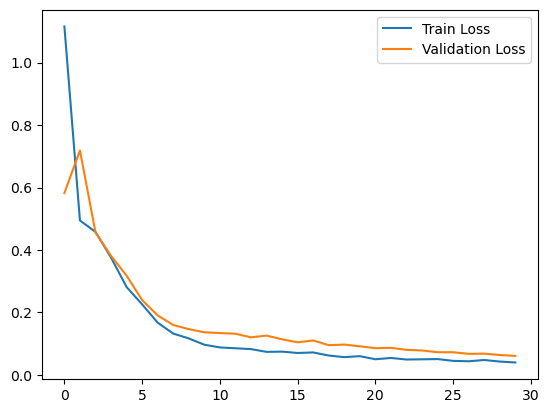

In [31]:
# plot metrics
plt.plot(metrics["epoch"], metrics["train_loss"], label="Train Loss")
plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Test Images

In [32]:
test_df = pd.read_csv(data_dir / "test-images.csv")
test_df.head()


,split,image_id,timestamp,filename,url,value,date,prcp,jday,dhour,obs,zero,rand,obs_z,prcp_z,jday_z,dhour_z
0,test-in,624034,2022-05-22 20:00:00,imagesets/33c0736b-f5fb-4da6-91b0-83a72c285382...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,6.680000,2022-05-22,7.45,142,16.000000,0.824776,0,0.112478,0.436951,0.113187,0.387363,0.750017
1,test-in,661236,2022-06-09 15:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,31.799000,2022-06-09,7.42,160,11.250278,1.502413,0,0.219296,0.591032,0.112732,0.436813,0.354198
2,test-in,3524434,2023-09-14 11:30:00,imagesets/28817548-7828-4365-9263-af78ce15b503...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,13.300000,2023-09-14,0.00,257,7.500000,1.123852,0,0.224699,0.504955,0.000000,0.703297,0.041668
3,test-in,1390235,2022-11-15 15:00:00,imagesets/e2a3b2b6-d391-481a-9814-dc61cf83a990...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.100000,2022-11-15,19.14,319,10.000000,0.612784,0,0.835279,0.388749,0.290793,0.873626,0.250006
4,test-in,2019452,2023-03-19 20:15:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,29.201111,2023-03-19,0.00,78,16.250278,1.465399,0,0.853963,0.582616,0.000000,0.211538,0.770874


In [33]:
# Create dataset
dataset = FlowPhotoDataset(test_df, images_dir)
dataset[0]

(tensor([[[0.3176, 0.3176, 0.3255,  ..., 0.9922, 0.9843, 0.9843],
          [0.3216, 0.3255, 0.3294,  ..., 0.9922, 0.9843, 0.9843],
          [0.3137, 0.3176, 0.3333,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.3804, 0.3804, 0.3843,  ..., 0.9961, 1.0000, 1.0000],
          [0.3765, 0.3804, 0.3843,  ..., 0.9961, 1.0000, 1.0000],
          [0.3647, 0.3725, 0.3765,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.2392, 0.2353, 0.2314,  ..., 0.7608, 0.7686, 0.7686],
          [0.2471, 0.2431, 0.2431,  ..., 0.7686, 0.7686, 0.7686],
          [0.2471, 0.2431, 0.2431,  ...,

In [34]:
dataset.table.describe()

,image_id,value,prcp,jday,dhour,obs,zero,rand,obs_z,prcp_z,jday_z,dhour_z
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.664340e+06,19.232092,4.663630,178.155000,12.862627,0.894935,0.0,0.507283,0.452904,0.070854,0.486690,0.488564
std,1.015261e+06,30.322921,9.029596,86.554773,3.439631,0.704506,0.0,0.281779,0.160190,0.137186,0.237788,0.286643
min,4.414980e+05,0.090000,0.000000,1.000000,7.000000,-1.045757,0.0,0.000334,0.011631,0.000000,0.000000,0.000000
25%,6.642732e+05,3.810000,0.000000,105.000000,9.750278,0.580920,0.0,0.266060,0.381504,0.000000,0.285714,0.229195
50%,1.644311e+06,11.000000,0.000000,186.000000,12.749722,1.041393,0.0,0.506959,0.486206,0.000000,0.508242,0.479155
75%,2.461374e+06,25.400000,5.660000,241.000000,16.000000,1.404834,0.0,0.759049,0.568844,0.085992,0.659341,0.750017
max,3.526010e+06,393.000000,65.820000,364.000000,18.999722,2.594393,0.0,0.996617,0.839325,1.000000,0.997253,1.000000


In [35]:
# Load model
model_path = model_dir / "model.pth"
checkpoint = torch.load(model_path, map_location=device)
params = checkpoint["params"]

model = ResNetRegressionNet(
    input_shape=(3, params["input_shape"][0], params["input_shape"][1]),
    transforms=checkpoint["transforms"],
    resnet_size=18,
    truncate=2,
)

#model = nn.DataParallel(model, device_ids=None)
model.load_state_dict(checkpoint["model_state_dict"])

model = model.to(device).eval()
model

/tmp/ipykernel_2170826/261073641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


ResNetRegressionNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [36]:
# Generate predictions
scores = []
with torch.no_grad():
    for image, _ in tqdm(dataset, desc="Generating predictions"):
        # Move image to device and get prediction
        image = image.to(device)
        transformed = model.transforms['eval'](image)
        output = model.forward(transformed.unsqueeze(0))
        score = output.detach().cpu().numpy().item()
        scores.append(score)
scores = np.array(scores)

Generating predictions: 100%|██████████| 1000/1000 [00:21<00:00, 45.77it/s]


In [38]:
test_df['score'] = scores
test_df.describe()

,image_id,value,prcp,jday,dhour,obs,zero,rand,obs_z,prcp_z,jday_z,dhour_z,score
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.664340e+06,19.232092,4.663630,178.155000,12.862627,0.894935,0.0,0.507283,0.452904,0.070854,0.486690,0.488564,0.918453
std,1.015261e+06,30.322921,9.029596,86.554773,3.439631,0.704506,0.0,0.281779,0.160190,0.137186,0.237788,0.286643,0.677612
min,4.414980e+05,0.090000,0.000000,1.000000,7.000000,-1.045757,0.0,0.000334,0.011631,0.000000,0.000000,0.000000,-0.381456
25%,6.642732e+05,3.810000,0.000000,105.000000,9.750278,0.580920,0.0,0.266060,0.381504,0.000000,0.285714,0.229195,0.498996
50%,1.644311e+06,11.000000,0.000000,186.000000,12.749722,1.041393,0.0,0.506959,0.486206,0.000000,0.508242,0.479155,1.077653
75%,2.461374e+06,25.400000,5.660000,241.000000,16.000000,1.404834,0.0,0.759049,0.568844,0.085992,0.659341,0.750017,1.455812
max,3.526010e+06,393.000000,65.820000,364.000000,18.999722,2.594393,0.0,0.996617,0.839325,1.000000,0.997253,1.000000,2.300018


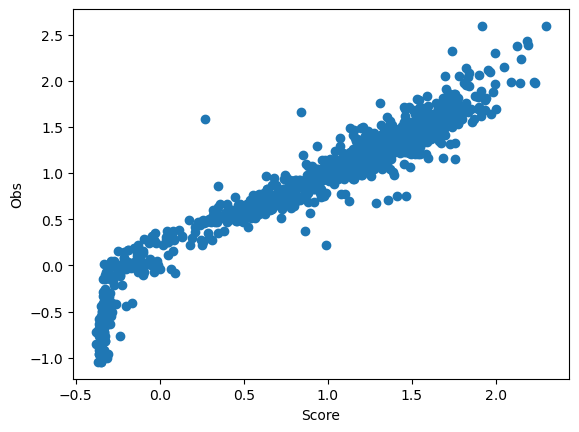

In [40]:
# plot score vs obs
plt.scatter(test_df['score'], test_df['obs'])
plt.xlabel('Score')
plt.ylabel('Obs')
plt.show()

In [41]:
# calculate error stats between obs and score
values = test_df['obs'].values
error = values - scores
print(f"Mean error: {error.mean()}, std error: {error.std()}")

import scipy.stats as stats
kendall_tau = stats.kendalltau(scores, values)[0]
spearman_rho = stats.spearmanr(scores, values)[0]
print(f"Kendall's tau: {kendall_tau}, Spearman's rho: {spearman_rho}")

# compute rmse
rmse = np.sqrt(np.mean(error**2))
print(f"RMSE: {rmse}")

test_stats = {
    "rmse": rmse,
    "kendall_tau": kendall_tau,
    "spearman_rho": spearman_rho
}
test_stats

Mean error: -0.023518412548860092, std error: 0.20661574987188086
Kendall's tau: 0.8459112082044867, Spearman's rho: 0.9597310106688599
RMSE: 0.2079499550948209


{'rmse': 0.2079499550948209,
 'kendall_tau': 0.8459112082044867,
 'spearman_rho': 0.9597310106688599}

## Auxiliary Features

In [42]:
auxiliary_features = ["obs_z_1"]
auxiliary_encoding_size = 32

run_dir = Path("/home/jeff/data/fpe/experiments/20241113-WB0-aux-reg/runs/aux_reg_02")
data_dir = run_dir / "input"
output_dir = run_dir / "output"
model_dir = run_dir / "model"
checkpoint_dir = run_dir / "checkpoints"

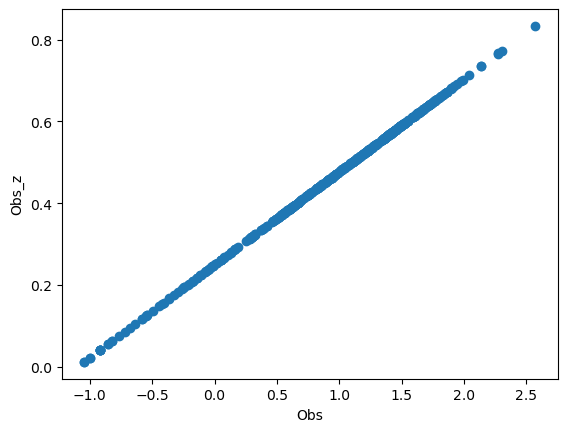

In [43]:
# plot obs vs obs_z
plt.scatter(train_df['obs_1'], train_df['obs_z_1'])
plt.xlabel('Obs')
plt.ylabel('Obs_z')
plt.show()

In [44]:
aux_train_ds = FlowPhotoDatasetWithAuxiliary(train_df, images_dir, auxiliary_features=auxiliary_features, col_image_id="image_id_1", col_timestamp="timestamp_1", col_filename="filename_1", col_label="obs_1")
aux_train_ds.table.describe()

,pair,image_id_1,timestamp_1,image_id_2,timestamp_2,label,obs_1,prcp_1,jday_1,dhour_1,...,obs_2,prcp_2,jday_2,dhour_2,zero_2,rand_2,obs_z_2,prcp_z_2,jday_z_2,dhour_z_2
count,500.000000,5.000000e+02,500,5.000000e+02,500,500.000000,500.000000,500.00000,500.000000,500.000000,...,500.000000,500.00000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3900.924000,1.455590e+06,2022-11-22 11:13:20.394000128,1.455590e+06,2022-11-22 11:13:20.394000128,0.000000,0.927080,4.32392,172.454000,12.882332,...,0.927080,4.32392,172.454000,12.882332,0.0,0.492142,0.460213,0.065693,0.471027,0.490206
min,18.000000,4.415210e+05,2022-02-02 23:00:00,4.415210e+05,2022-02-02 23:00:00,-1.000000,-1.045757,0.00000,1.000000,7.000000,...,-1.045757,0.00000,1.000000,7.000000,0.0,0.000544,0.011631,0.000000,0.000000,0.000000
25%,1840.000000,6.620900e+05,2022-06-18 16:15:00,6.620900e+05,2022-06-18 16:15:00,-1.000000,0.559907,0.00000,98.750000,9.750278,...,0.559907,0.00000,98.750000,9.750278,0.0,0.259022,0.376726,0.000000,0.268544,0.229195
50%,3635.500000,1.391296e+06,2022-11-21 09:52:30,1.391296e+06,2022-11-21 09:52:30,0.000000,1.079166,0.00000,171.000000,12.750417,...,1.079166,0.00000,171.000000,12.750417,0.0,0.486948,0.494794,0.000000,0.467033,0.479212
75%,6174.000000,2.036689e+06,2023-04-06 17:07:30,2.036689e+06,2023-04-06 17:07:30,1.000000,1.425709,4.66000,237.250000,16.000000,...,1.425709,4.66000,237.250000,16.000000,0.0,0.726971,0.573591,0.070799,0.649038,0.750017
max,8157.000000,3.525782e+06,2023-09-28 12:30:00,3.525782e+06,2023-09-28 12:30:00,1.000000,2.569431,55.12000,365.000000,18.999722,...,2.569431,55.12000,365.000000,18.999722,0.0,0.999180,0.833650,0.837435,1.000000,1.000000
std,2437.878055,8.535688e+05,NaN,8.535688e+05,NaN,0.941154,0.686382,8.64055,91.514598,3.515008,...,0.686382,8.64055,91.514598,3.515008,0.0,0.284643,0.156069,0.131275,0.251414,0.292924


In [47]:
aux_train_ds.transform = transforms["train"]
aux_val_ds = FlowPhotoDatasetWithAuxiliary(
    val_df,
    images_dir,
    auxiliary_features=auxiliary_features,
    col_image_id="image_id_1",
    col_timestamp="timestamp_1",
    col_filename="filename_1",
    col_label="obs_1",
    transform=transforms["eval"]
)

In [48]:
batch_size = 64
num_workers = 4

aux_train_dl = DataLoader(
    aux_train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
aux_val_dl = DataLoader(
    aux_val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [49]:
aux_model = ResNetRegressionNetWithAuxiliary(
    input_shape=(3, input_shape[0], input_shape[1]),
    transforms=transforms,
    resnet_size=18,
    truncate=2,
    auxiliary_size=len(auxiliary_features),
    auxiliary_encoding_size=auxiliary_encoding_size
)
aux_model

ResNetRegressionNetWithAuxiliary(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [50]:
len(list(model.children())), len(list(aux_model.children()))

(3, 4)

In [51]:
len(list(model.parameters())), len(list(aux_model.parameters()))


(66, 70)

In [52]:
# Freeze resnet backbone initially
for p in list(aux_model.children())[0].parameters():
    p.requires_grad = False

# model = nn.DataParallel(model, device_ids=[0])
aux_model = aux_model.to(device)
aux_model

ResNetRegressionNetWithAuxiliary(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [53]:
lr = 0.001
momentum = 0.9
scheduler_patience = 1
scheduler_factor = 0.5
criterion = nn.MSELoss()
optimizer = SGD(aux_model.parameters(), lr=lr, momentum=momentum)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=scheduler_patience, factor=scheduler_factor)

In [54]:

def aux_fit(model, criterion, optimizer, train_dl, device, epoch_num=None, verbose=False):
    """Train model for one epoch.

    Args:
        model (torch.nn.Module): network to train
        criterion (torch.nn.Module): loss function(s) used to train network weights
        optimizer (torch.optim.Optimizer): algorithm used to optimize network weights
        train_dl (torch.utils.DataLoader): data loader for training set
    Returns:
        batch_loss_logger.avg (float): average criterion loss per batch during training
    """
    model.train()  # ensure model is in train mode
    # train_dl.dataset.train()  # ensure train transforms are applied
    batch_loss_logger = MetricLogger()

    for bidx, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        img, aux, label = batch
        label = label.float()
        if next(aux_model.parameters()).is_cuda:
            img, aux, label = img.to(device), aux.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = aux_model(img, aux)
        loss = criterion(outputs, label)
        batch_loss_logger.update(loss.item())
        loss.backward()
        optimizer.step()

    return batch_loss_logger.avg

def aux_validate(model, criterions, dl, device):
    """Calculate multiple criterion for a model on a dataset."""
    
    model.eval()
    criterion_loggers = [MetricLogger() for i in range(len(criterions))]
    with torch.no_grad():  # ensure no gradients are computed
        for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
            model_outputs = {}
            for i, c in enumerate(criterions):
                if "outputs" not in model_outputs.keys():
                    # store model outputs from forward pass in case another criterion needs the same
                    img, aux, label = batch
                    if next(aux_model.parameters()).is_cuda:
                        img, aux, label = img.to(device), aux.to(device), label.to(device)
                    outputs = aux_model(img, aux)
                    model_outputs["outputs"] = outputs
                else:
                    # load previously computed model outputs from forward pass
                    outputs = model_outputs["outputs"]
                cval = c(outputs, label)
                criterion_loggers[i].update(cval.item())
    return [cl.avg for cl in criterion_loggers]

In [55]:
# epochs = 30
# unfreeze_after = 2
# metrics = {"epoch": [], "train_loss": [], "val_loss": []}
# min_val_loss = float('inf')
# best_epoch = None
# total_train_time = 0
# epoch_times = []

# aux_model.train()  # ensure model is in train mode

# batch = next(iter(aux_train_dl))
# img, aux, label = batch
# img = img.float()
# aux = aux.float()
# label = label.float()
# if next(aux_model.parameters()).is_cuda:
#     img, aux, label = img.to(device), aux.to(device), label.to(device)
# optimizer.zero_grad()
# outputs = aux_model(img, aux)
# outputs

In [56]:
epochs = 30
unfreeze_after = 2
aux_metrics = {"epoch": [], "train_loss": [], "val_loss": []}
min_val_loss = float('inf')
best_epoch = None
total_train_time = 0
epoch_times = []
aux_model.train()

# Set seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    print("fit")
    train_loss = aux_fit(aux_model, criterion, optimizer, aux_train_dl, device, epoch)
    aux_metrics["train_loss"].append(train_loss)
    aux_metrics["epoch"].append(epoch)
    print(f"Train loss: {train_loss}")

    print("validate")
    val_loss = aux_validate(aux_model, [criterion], aux_val_dl, device)[0]
    aux_metrics["val_loss"].append(val_loss)
    print(f"Validation loss: {val_loss}")

    # Learning rate update
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"Learning rate adjusted: {old_lr:.6f} -> {new_lr:.6f}")

    # Model saving
    checkpoint_path = checkpoint_dir / f"epoch_{epoch:02d}.pth"
    save_checkpoint(
        checkpoint_path, epoch, aux_model, optimizer, train_loss,
        transforms,
        {
            "aspect": aspect,
            "input_shape": input_shape,
            "img_sample_mean": img_mean,
            "img_sample_std": img_std
        }
    )

    # Check for improvement
    if epoch == 0:
        print("Initial checkpoint - Saving")
    elif val_loss < min_val_loss:
        improvement = min_val_loss - val_loss
        print(f"Model validation loss improved by {improvement:.4f} - Saving checkpoint")
        best_model_path = model_dir / "model.pth"
        shutil.copy(checkpoint_path, best_model_path)
        min_val_loss = val_loss
        best_epoch = epoch

    # Save metrics
    pd.DataFrame(aux_metrics).to_csv(output_dir / "train" / "metrics.csv", index=False)

    # Backbone unfreezing
    if (epoch + 1) == unfreeze_after:
        print(f"Unfreezing CNN backbone at epoch {epoch + 1}")
        for p in list(aux_model.children())[0].parameters():
            p.requires_grad = True

Epoch 1/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]

Train loss: 1.1315887570381165
validate



100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

Validation loss: 0.6058172424934123
Initial checkpoint - Saving
Epoch 2/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.14it/s]

Train loss: 0.5063234940171242
validate



100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

Validation loss: 0.7760310169255829
Model validation loss improved by inf - Saving checkpoint
Unfreezing CNN backbone at epoch 2
Epoch 3/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.4948195703327656
validate


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Validation loss: 0.5441332153048521
Model validation loss improved by 0.2319 - Saving checkpoint
Epoch 4/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.3862658180296421
validate


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Validation loss: 0.42113130392955767
Model validation loss improved by 0.1230 - Saving checkpoint
Epoch 5/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.31640976667404175
validate


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Validation loss: 0.3669216616999649
Model validation loss improved by 0.0542 - Saving checkpoint
Epoch 6/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.2522374913096428
validate


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Validation loss: 0.30617136168044734
Model validation loss improved by 0.0608 - Saving checkpoint
Epoch 7/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.19867453910410404
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.23581071628368247
Model validation loss improved by 0.0704 - Saving checkpoint
Epoch 8/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.15881984494626522
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.19425754141177975
Model validation loss improved by 0.0416 - Saving checkpoint
Epoch 9/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train loss: 0.13551817275583744
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.17919918356501657
Model validation loss improved by 0.0151 - Saving checkpoint
Epoch 10/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.10795548744499683
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.15478527418373278
Model validation loss improved by 0.0244 - Saving checkpoint
Epoch 11/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.09603710565716028
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.14862956339036276
Model validation loss improved by 0.0062 - Saving checkpoint
Epoch 12/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.09417573874816298
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.14691664474024102
Model validation loss improved by 0.0017 - Saving checkpoint
Epoch 13/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.08599973376840353
validate


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Validation loss: 0.13078470845375278
Model validation loss improved by 0.0161 - Saving checkpoint
Epoch 14/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Train loss: 0.07754530245438218
validate


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

Validation loss: 0.13993513054731327
Epoch 15/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.0794237251393497
validate


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Validation loss: 0.12498142493654116
Model validation loss improved by 0.0058 - Saving checkpoint
Epoch 16/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Train loss: 0.07455358887091279
validate


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Validation loss: 0.11278724569262488
Model validation loss improved by 0.0122 - Saving checkpoint
Epoch 17/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.07526949513703585
validate


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

Validation loss: 0.12134718037401065
Epoch 18/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.06523900129832327
validate


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Validation loss: 0.10193232437655916
Model validation loss improved by 0.0109 - Saving checkpoint
Epoch 19/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.060438170563429594
validate


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Validation loss: 0.10521815686078712
Epoch 20/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.06222789455205202
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.097174199228037
Model validation loss improved by 0.0048 - Saving checkpoint
Epoch 21/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.0520995226688683
validate


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Validation loss: 0.08950058786891286
Model validation loss improved by 0.0077 - Saving checkpoint
Epoch 22/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

Train loss: 0.05619337456300855
validate



100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

Validation loss: 0.09076751394591892
Epoch 23/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.05165650160051882
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.08255651645663131
Model validation loss improved by 0.0069 - Saving checkpoint
Epoch 24/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.05142858158797026
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.08064210520936302
Model validation loss improved by 0.0019 - Saving checkpoint
Epoch 25/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.050110381562262774
validate


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Validation loss: 0.07265083615993706
Model validation loss improved by 0.0080 - Saving checkpoint
Epoch 26/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Train loss: 0.04439612105488777
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

Validation loss: 0.07304181012138225
Epoch 27/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train loss: 0.04313091072253883
validate


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Validation loss: 0.06536954205679271
Model validation loss improved by 0.0073 - Saving checkpoint
Epoch 28/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Train loss: 0.048082994762808084
validate


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

Validation loss: 0.06628462585501557
Epoch 29/30
fit



100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.042003815760836005
validate


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Validation loss: 0.060246570817122556
Model validation loss improved by 0.0051 - Saving checkpoint
Epoch 30/30
fit


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Train loss: 0.03787365322932601
validate


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Validation loss: 0.05721707879584411
Model validation loss improved by 0.0030 - Saving checkpoint


### Test Images

In [62]:
aux_test_df = pd.read_csv(data_dir / "test-images.csv")
aux_test_df.head()

,split,image_id,timestamp,filename,url,value,date,prcp,jday,dhour,obs,zero,rand,obs_z,prcp_z,jday_z,dhour_z
0,test-in,624034,2022-05-22 20:00:00,imagesets/33c0736b-f5fb-4da6-91b0-83a72c285382...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,6.680000,2022-05-22,7.45,142,16.000000,0.824776,0,0.112478,0.436951,0.113187,0.387363,0.750017
1,test-in,661236,2022-06-09 15:15:01,imagesets/cb2b67b0-0f07-4351-b96d-2659d5b56c9f...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,31.799000,2022-06-09,7.42,160,11.250278,1.502413,0,0.219296,0.591032,0.112732,0.436813,0.354198
2,test-in,3524434,2023-09-14 11:30:00,imagesets/28817548-7828-4365-9263-af78ce15b503...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,13.300000,2023-09-14,0.00,257,7.500000,1.123852,0,0.224699,0.504955,0.000000,0.703297,0.041668
3,test-in,1390235,2022-11-15 15:00:00,imagesets/e2a3b2b6-d391-481a-9814-dc61cf83a990...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,4.100000,2022-11-15,19.14,319,10.000000,0.612784,0,0.835279,0.388749,0.290793,0.873626,0.250006
4,test-in,2019452,2023-03-19 20:15:01,imagesets/27aae6d9-9417-4b53-bf6a-cd2ce8139ba1...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,29.201111,2023-03-19,0.00,78,16.250278,1.465399,0,0.853963,0.582616,0.000000,0.211538,0.770874


In [63]:
# Create dataset
aux_dataset = FlowPhotoDatasetWithAuxiliary(aux_test_df, images_dir, auxiliary_features=['obs_z'], col_image_id="image_id", col_timestamp="timestamp", col_filename="filename", col_label="obs")
aux_dataset[0]

(tensor([[[0.3176, 0.3176, 0.3255,  ..., 0.9922, 0.9843, 0.9843],
          [0.3216, 0.3255, 0.3294,  ..., 0.9922, 0.9843, 0.9843],
          [0.3137, 0.3176, 0.3333,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961]],
 
         [[0.3804, 0.3804, 0.3843,  ..., 0.9961, 1.0000, 1.0000],
          [0.3765, 0.3804, 0.3843,  ..., 0.9961, 1.0000, 1.0000],
          [0.3647, 0.3725, 0.3765,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.2392, 0.2353, 0.2314,  ..., 0.7608, 0.7686, 0.7686],
          [0.2471, 0.2431, 0.2431,  ..., 0.7686, 0.7686, 0.7686],
          [0.2471, 0.2431, 0.2431,  ...,

In [64]:
# Load model
model_path = model_dir / "model.pth"
checkpoint = torch.load(model_path, map_location=device)
params = checkpoint["params"]

aux_model = ResNetRegressionNetWithAuxiliary(
    input_shape=(3, params["input_shape"][0], params["input_shape"][1]),
    transforms=checkpoint["transforms"],
    resnet_size=18,
    truncate=2,
    auxiliary_size=len(auxiliary_features),
    auxiliary_encoding_size=auxiliary_encoding_size
)

aux_model.load_state_dict(checkpoint["model_state_dict"])

aux_model = aux_model.to(device).eval()
aux_model

/tmp/ipykernel_2170826/2794913697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


ResNetRegressionNetWithAuxiliary(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [65]:
# Generate predictions
scores = []
with torch.no_grad():
    for image, aux, _ in tqdm(aux_dataset, desc="Generating predictions"):
        # Move image to device and get prediction
        image = image.to(device)
        aux = aux.to(device)
        transformed = aux_model.transforms['eval'](image)
        output = aux_model.forward(transformed.unsqueeze(0), aux.unsqueeze(0))
        score = output.detach().cpu().numpy().item()
        scores.append(score)
scores = np.array(scores)

Generating predictions: 100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s]


Mean error: -0.038823968330209624, std error: 0.20398216347989706
Kendall's tau: 0.8439627876166736, Spearman's rho: 0.9596616137927196
RMSE: 0.20764398265985115


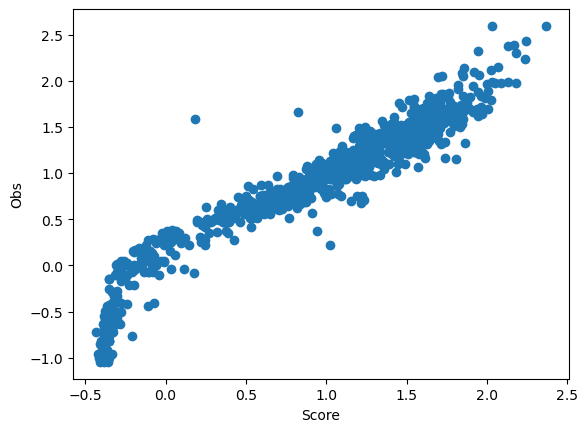

In [66]:
aux_test_df['score'] = scores
aux_test_df.describe()

# calculate error stats between obs and score
values = aux_test_df['obs'].values
error = values - scores
print(f"Mean error: {error.mean()}, std error: {error.std()}")

import scipy.stats as stats
kendall_tau = stats.kendalltau(scores, values)[0]
spearman_rho = stats.spearmanr(scores, values)[0]
print(f"Kendall's tau: {kendall_tau}, Spearman's rho: {spearman_rho}")

# compute rmse
rmse = np.sqrt(np.mean(error**2))
print(f"RMSE: {rmse}")

# plot score vs obs
plt.scatter(aux_test_df['score'], aux_test_df['obs'])
plt.xlabel('Score')
plt.ylabel('Obs')
plt.show()